In [1]:
import numpy as np
import matplotlib.pyplot as plt
import functools
import operator
import math

gdk:  1000 (2, 2) 2 2


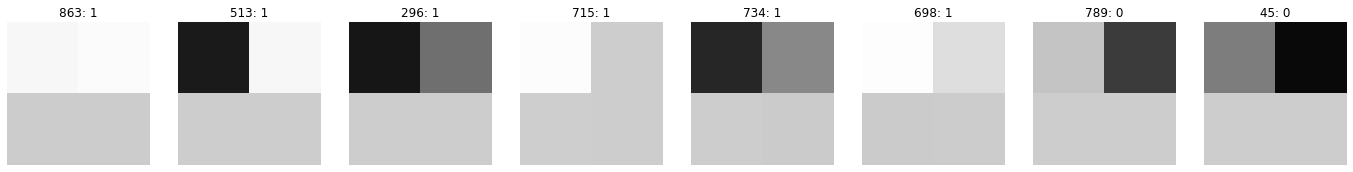

In [2]:
def show(data, labels=None, s=8):
    n, c, j = data.shape[0], data.shape[-1], 1
    labels = [None] * data.shape[0] if labels is None else labels
    plt.figure(figsize=(3 * s, 3))
    for i in np.random.randint(0, n, s):
        plt.subplot(1, s, j)
        plt.imshow(data[i], cmap="Greys", vmin=0, vmax=1)
        plt.title(str(i) + ": " + str(labels[i]))
        plt.axis("off")
        j += 1
    plt.show()

def gdk(n=1000, d=(2, 2), k=2, c=2, **kwargs):
    pd = functools.reduce(operator.mul, d, 1)
    assert(k <= pd)
    data = np.ones((n, *d))

    mask = np.arange(0, pd).reshape(d) < k
    common = np.ones((n, *d)) * 0.3
    random = np.random.random((n, *d))
    data = np.where(mask, random, common + 0.01 * random)
    labels = np.array([
        int((math.sin(d.flatten()[0] * 10) + 1) / 2 * c)
        for d in data])

    print("gdk: ", n, d, k, c)
    show(data, labels, **kwargs)
    return data, labels

gdk();

gdk:  8192 (2, 2) 2 2


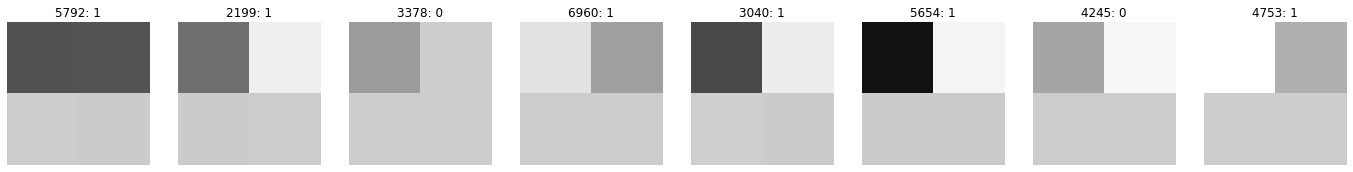

gdk:  1024 (2, 2) 2 2


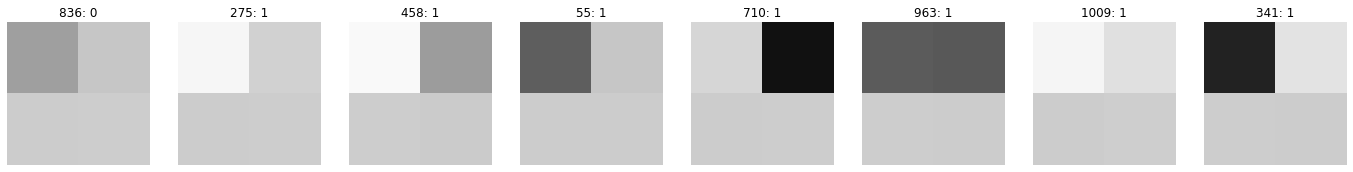

loss 334.43294069231763
epoch 1 0.6279296875
loss 315.7558981084052
epoch 2 0.6279296875
loss 281.2710380216646
epoch 3 0.6279296875
loss 239.30974440567164
epoch 4 0.8466796875
loss 202.65861958868862
epoch 5 0.9140625
loss 176.86367898472943
epoch 6 0.9287109375
loss 159.40161343140005
epoch 7 0.9375
loss 146.02819354751048
epoch 8 0.94140625
loss 134.3082143106666
epoch 9 0.939453125
loss 123.54878069427423
epoch 10 0.94140625
loss 113.89712619209725
epoch 11 0.939453125
loss 105.1548669015448
epoch 12 0.939453125
loss 97.24372785831777
epoch 13 0.9404296875
loss 90.29463798103401
epoch 14 0.947265625
loss 84.29653265155022
epoch 15 0.9560546875
loss 79.08154399474557
epoch 16 0.9609375
loss 74.56590878882218
epoch 17 0.9658203125
loss 70.59267108709598
epoch 18 0.9677734375
loss 67.08183867774709
epoch 19 0.9736328125
loss 63.972483558546784
epoch 20 0.9794921875
loss 61.19992328196437
epoch 21 0.98046875
loss 58.72129678373439
epoch 22 0.9814453125
loss 56.49292429072127
epoch 23 

In [24]:
import jax
from jax.experimental import stax, optimizers
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
key = jax.random.PRNGKey(0)

ns, d, k, c, batch = (8192, 1024), (2, 2), 2, 2, 512
init_fun, model = jax.experimental.stax.serial(
    jax.experimental.stax.Flatten,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(16),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Dense(c),
    jax.experimental.stax.LogSoftmax)
_, params = init_fun(key, (batch, *d))
opt_init, opt_update, get_params = \
    jax.experimental.optimizers.adam(0.005)
opt_state = opt_init(params)

def meval(model, params, xs, ys):
    correct = 0
    for step in range(len(xs) // batch):
        x, y = xs[step * batch:(step + 1) * batch], \
            ys[step * batch:(step + 1) * batch]
        pred = np.argmax(model(params, x), axis=1)
        correct += np.sum(pred == y)
    return correct / len(xs)

trainx, trainy, testx, testy = \
    *gdk(ns[0], d, k, c), *gdk(ns[1], d, k, c)
for epoch in range(30):
    for step in range(ns[0] // batch):
        x, y = trainx[step * batch:(step + 1) * batch], \
            trainy[step * batch:(step + 1) * batch]
        loss, grads = jax.value_and_grad(
            lambda params, xs, ys: -np.sum(model(params, xs) *
            np.array([[1 if i == label else 0
                for i in range(c)]
                for label in ys])) # adaptor for softmax out
        )(params, x, y)
        print("\rloss", loss, end="")
        opt_state = opt_update(0, grads, opt_state)
        params = get_params(opt_state)
    print("\nepoch", epoch + 1, "nerr", 1 - meval(model, params, testx, testy))

gdk:  8192 (2, 2) 2 2


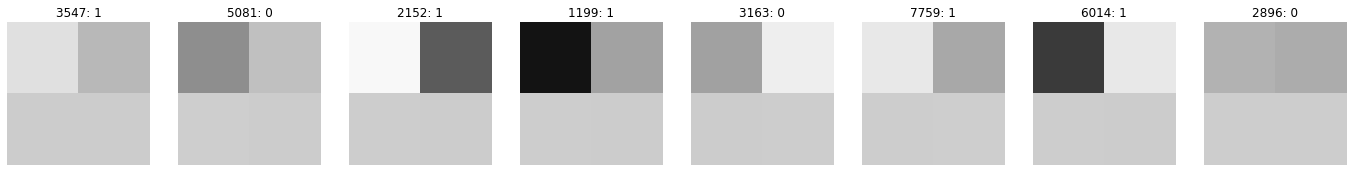

[(0.360504982439392, 0.3063408333704571, -0.011205728560064228), (0.7287519059780019, 0.3047016672801009, -3.793530299931222), (0.4391463771795645, 0.3036693736254808, -0.002010947093919395), (0.20973370755551457, 0.30722645490053924, -11.100564036124613), (0.18888183957507776, 0.30873802772274156, -13.399644186340382)]


ValueError: not enough values to unpack (expected 2, got 1)

In [48]:
# pixel (1, 1) and (2, 2) -> class 0 probability from model
xs, ys, X, Y, Z, xs2 = *gdk(8192, d, k, c), [], [], [], np.random.random((8192, *d))
for step in range(len(xs) // batch):
    x, y, x2 = xs[step * batch:(step + 1) * batch], \
        ys[step * batch:(step + 1) * batch], \
        xs2[step * batch:(step + 1) * batch]
    for i in zip(x[:, 0, 0], x[:, 1, 1], model(params, xs)[:, 0]):
        X.append(i[0])
        Y.append(i[1])
        Z.append(i[2])
    for i in zip(x[:, 0, 0], x[:, 1, 1], model(params, xs2)[:, 0]):
        X.append(i[0])
        Y.append(i[1])
        Z.append(i[2])
print(gdps[:5])

plt.figure(figsize=(5, 5))
plt.subplot(1, 1, 1)
plt.pcolormesh(X,Y,Z, shading='gouraud', cmap='jet')
plt.show()

gdk:  10000 (2, 2) 2 2


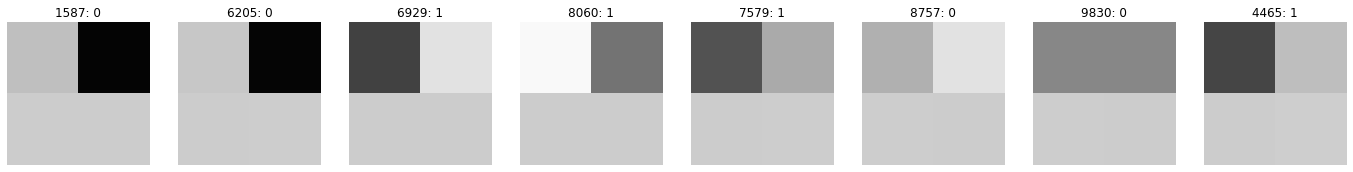

gdk:  1000 (2, 2) 2 2


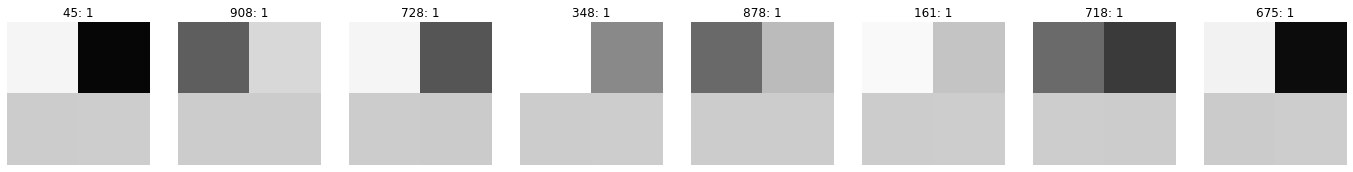

Epoch 1/10
79/79 [==============================] - 1s 9ms/step - loss: 0.6651 - accuracy: 0.6264 - val_loss: 0.6356 - val_accuracy: 0.6450
Epoch 2/10
79/79 [==============================] - 1s 8ms/step - loss: 0.6384 - accuracy: 0.6296 - val_loss: 0.6117 - val_accuracy: 0.6450
Epoch 3/10
79/79 [==============================] - 1s 7ms/step - loss: 0.6141 - accuracy: 0.6313 - val_loss: 0.5856 - val_accuracy: 0.6450
Epoch 4/10
79/79 [==============================] - 1s 7ms/step - loss: 0.5871 - accuracy: 0.6310 - val_loss: 0.5525 - val_accuracy: 0.6750
Epoch 5/10
79/79 [==============================] - 1s 7ms/step - loss: 0.5525 - accuracy: 0.6871 - val_loss: 0.5144 - val_accuracy: 0.7790
Epoch 6/10
79/79 [==============================] - 1s 7ms/step - loss: 0.5170 - accuracy: 0.7967 - val_loss: 0.4760 - val_accuracy: 0.8500
Epoch 7/10
79/79 [==============================] - 1s 7ms/step - loss: 0.4736 - accuracy: 0.8839 - val_loss: 0.4421 - val_accuracy: 0.8870
Epoch 8/10
79/79 [==

In [77]:
import tensorflow as tf
from tensorflow import keras

def rexp(model, ns, d, k, c, batch, epochs, norm, eps, step, iters, batch2):
    trainx, trainy, testx, testy = *gdk(ns[0], d, k, c), *gdk(ns[1], d, k, c)
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer="adam",
        metrics=["accuracy"])
    model.fit(
        trainx, trainy,
        batch_size=batch,
        epochs=epochs,
        validation_data=(testx, testy),
        verbose=1)
    model.trainable = False
    
    from art.estimators.classification import TensorFlowV2Classifier
    from art.attacks.evasion import ProjectedGradientDescent
    artm = TensorFlowV2Classifier(
        model=model,
        input_shape=d,
        nb_classes=c,
        loss_object=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        clip_values=[0, 1])
    art = ProjectedGradientDescent(
        artm,
        norm=norm,
        eps=eps,
        eps_step=step,
        max_iter=iters,
        batch_size=batch2)
  
    testxa = art.generate(testx, y=testy)
    ret = (
        model,
        trainx, trainy, testx, testy,
        testxa,
        model.evaluate(trainx, trainy, verbose=0)[1],
        model.evaluate(testx, testy, verbose=0)[1],
        model.evaluate(testxa, testy, verbose=0)[1])
    print(ret[-3:])
    return ret

rexp(keras.Sequential([
        keras.Input(shape=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(8, activation="relu"),
        keras.layers.Dense(2, activation="softmax")]),
    (10000, 1000), (2, 2), 2, 2, 128, 10,
    2, 0.08, 0.005, 15, 64);

In [ ]:
def rexp(
    n,
    split,
    gmod
):
